In [1]:
import sys, os
import numpy as np
import time, h5py

from utils import default_paths, nsd_utils, texture_utils, prf_utils
from model_fitting import initialize_fitting 
import argparse
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

In [3]:
ims2load = np.arange(0,5000)
subject=1;

if subject<9:
    image_data = nsd_utils.get_image_data(subject)
elif subject==999:
    from utils import coco_utils
    image_data = coco_utils.load_indep_coco_images(n_pix=240)
image_data = nsd_utils.image_uncolorize_fn(image_data[ims2load,:,:,:])
# image_data = image_data[ims2use,:,:,:]
n_images = image_data.shape[0]


Loading images for subject 1

image data size: (10000, 3, 240, 240) , dtype: uint8 , value range: 0 255


In [4]:
fn2load = os.path.join(default_paths.stim_labels_root,'S%d_face.npy'%subject)
print(fn2load)
d = np.load(fn2load, allow_pickle=True).item()
has_face = d['has_face']
has_face_wholeimage = d['has_face_wholeimage']

/user_data/mmhender/nsd/labels/S1_face.npy


In [5]:
prf_ind = 100;

In [21]:
which_prf_grid=5
labels_folder = os.path.join(default_paths.stim_labels_root,'S%d_within_prf_grid%d'%(subject, which_prf_grid))    
fn2load = os.path.join(labels_folder, 'S%d_cocolabs_binary_prf%d.csv'%(subject, prf_ind))
print(fn2load)
coco_df = pd.read_csv(fn2load, index_col = 0)
has_person = np.array(coco_df['person'])

/user_data/mmhender/nsd/labels/S1_within_prf_grid5/S1_cocolabs_binary_prf100.csv


In [22]:
fn2load = os.path.join(default_paths.stim_labels_root, 'S%d_cocolabs_binary.csv'%(subject))
print(fn2load)
coco_df = pd.read_csv(fn2load, index_col = 0)
has_person_wholeimage = np.array(coco_df['person'])

/user_data/mmhender/nsd/labels/S1_cocolabs_binary.csv


#### count face/person label overlap
neither / person only / face only / both

In [23]:
un, counts = np.unique(np.array([has_face[:,prf_ind], has_person]).T,axis=0, return_counts=True)
print(un, counts)

[[0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 1.]] [8922  694   25  359]


In [24]:
un, counts = np.unique(np.array([has_face_wholeimage, has_person_wholeimage]).T,axis=0, return_counts=True)
print(un, counts)

[[0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 1.]] [4860 2034   66 3040]


In [10]:
which_prf_grid=5
models = initialize_fitting.get_prf_models(which_grid=which_prf_grid)    

prf_params = models[prf_ind,:]    
x,y,sigma = prf_params
n_pix = 240
aperture=1.0
prf = prf_utils.gauss_2d(center=[x, y], sd=sigma, patch_size=n_pix, aperture=1.0, \
                                      dtype=np.float32)
prf_mask = prf_utils.get_prf_mask(center=[x, y], sd=sigma, patch_size=n_pix)
mask_sum = np.sum(prf_mask)
min_pix_req = np.ceil(mask_sum*0.10)

n_prf_sd_out = 2
prf_bbox = texture_utils.get_bbox_from_prf(prf_params, (n_pix, n_pix), n_prf_sd_out, \
                                                   min_pix=None, verbose=False, force_square=False)

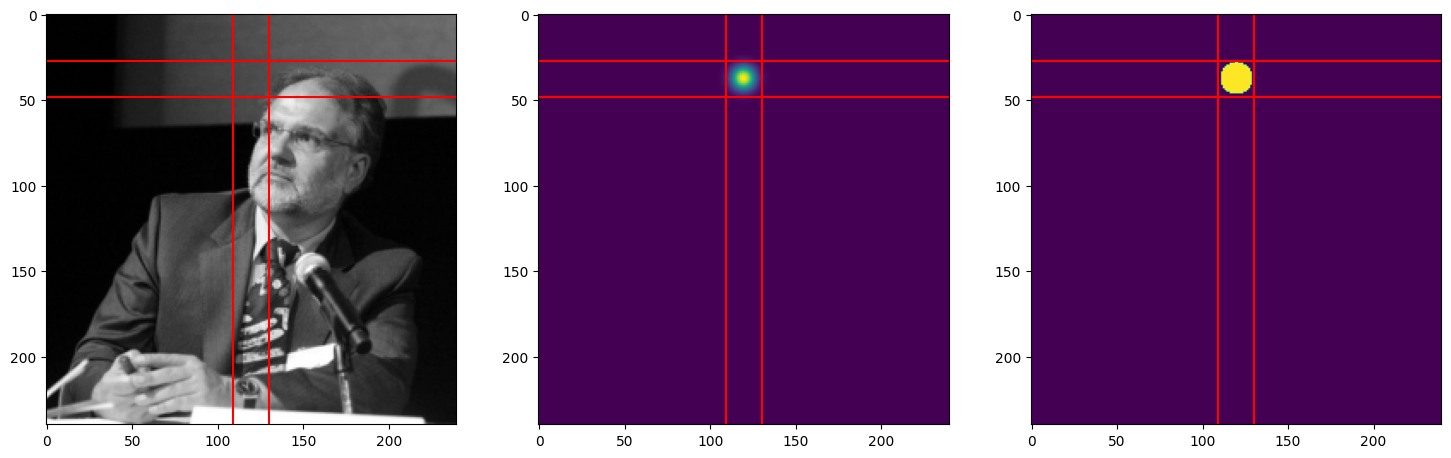

In [11]:
# Plot pRF bounding boxes

ii = np.where(has_face[:,prf_ind])[0][0]
nsd_image = np.moveaxis(image_data[ii,:,:,:], [0],[2])

plt.figure(figsize=(18,6));
plt.subplot(1,3,1)
plt.imshow(nsd_image, cmap='gray')
# show the prf on top to make sure it is where it should be
plt.axhline([prf_bbox[0]],color='r')
plt.axhline([prf_bbox[1]],color='r')
plt.axvline([prf_bbox[2]],color='r')
plt.axvline([prf_bbox[3]],color='r')

plt.subplot(1,3,2)
plt.imshow(prf)
# plt.colorbar()
plt.axhline([prf_bbox[0]],color='r')
plt.axhline([prf_bbox[1]],color='r')
plt.axvline([prf_bbox[2]],color='r')
plt.axvline([prf_bbox[3]],color='r')

plt.subplot(1,3,3)
plt.imshow(prf_mask)
plt.axhline([prf_bbox[0]],color='r')
plt.axhline([prf_bbox[1]],color='r')
plt.axvline([prf_bbox[2]],color='r')
plt.axvline([prf_bbox[3]],color='r')

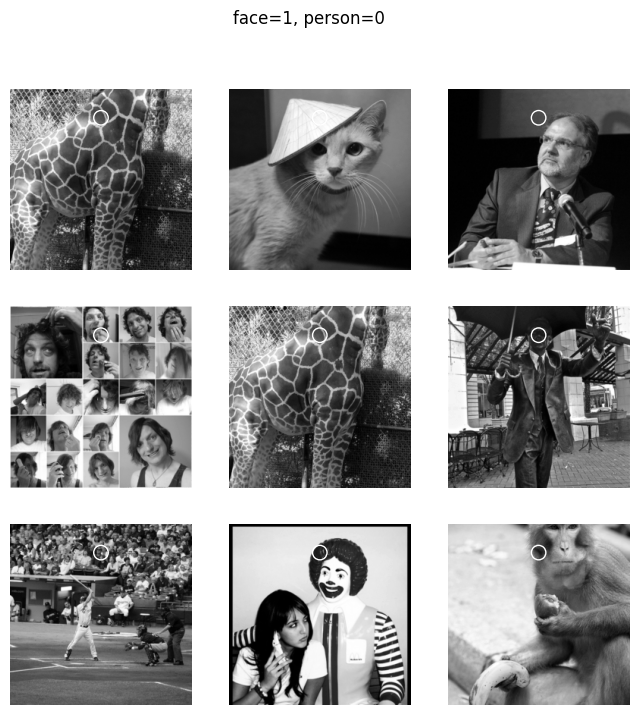

In [13]:
# plot examples - "has face" patches

ims2use = np.where((has_face[:,prf_ind]==1) & (has_person==0) & \
                   np.isin(np.arange(10000), ims2load))[0]

images2plot = np.random.choice(ims2use,9);

center_in_image = np.array((n_pix/2 + x*n_pix, n_pix/2 - n_pix*y))
size_in_image = 2*sigma*n_pix

plt.figure(figsize=(8,8));

for ii, im in enumerate(images2plot):
    ax = plt.subplot(3,3,ii+1);
    plt.imshow(np.moveaxis(image_data[im,:,:,:],[0],[2]),cmap='gray')
    circ = matplotlib.patches.Circle(center_in_image, size_in_image, 
                                                 color = 'w', fill=False)
    ax.add_artist(circ)
    plt.axis('off')
    
    plt.suptitle('face=%d, person=%d'%(has_face[im, prf_ind], has_person[im]))

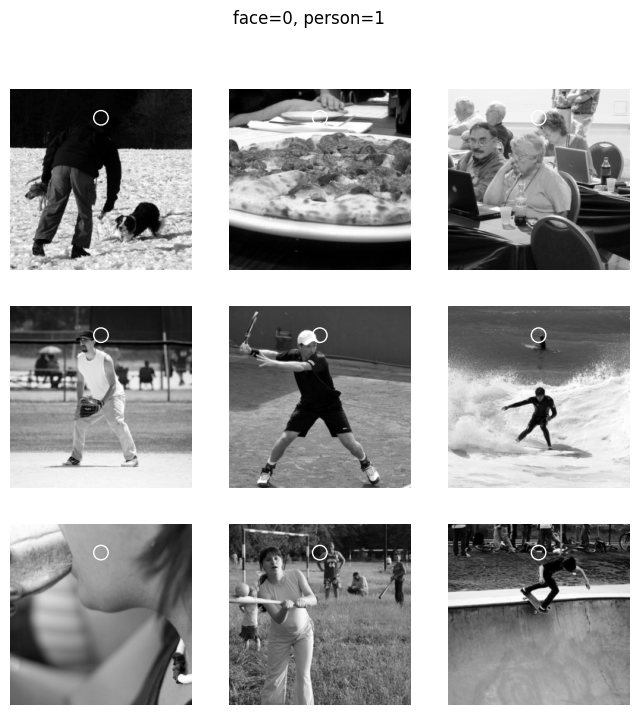

In [15]:
# plot examples - "has person" patches

ims2use = np.where((has_face[:,prf_ind]==0) & (has_person==1) & \
                   np.isin(np.arange(10000), ims2load))[0]

images2plot = np.random.choice(ims2use,9);

center_in_image = np.array((n_pix/2 + x*n_pix, n_pix/2 - n_pix*y))
size_in_image = 2*sigma*n_pix

plt.figure(figsize=(8,8));

for ii, im in enumerate(images2plot):
    ax = plt.subplot(3,3,ii+1);
    plt.imshow(np.moveaxis(image_data[im,:,:,:],[0],[2]),cmap='gray')
    circ = matplotlib.patches.Circle(center_in_image, size_in_image, 
                                                 color = 'w', fill=False)
    ax.add_artist(circ)
    plt.axis('off')
    
    plt.suptitle('face=%d, person=%d'%(has_face[im, prf_ind], has_person[im]))

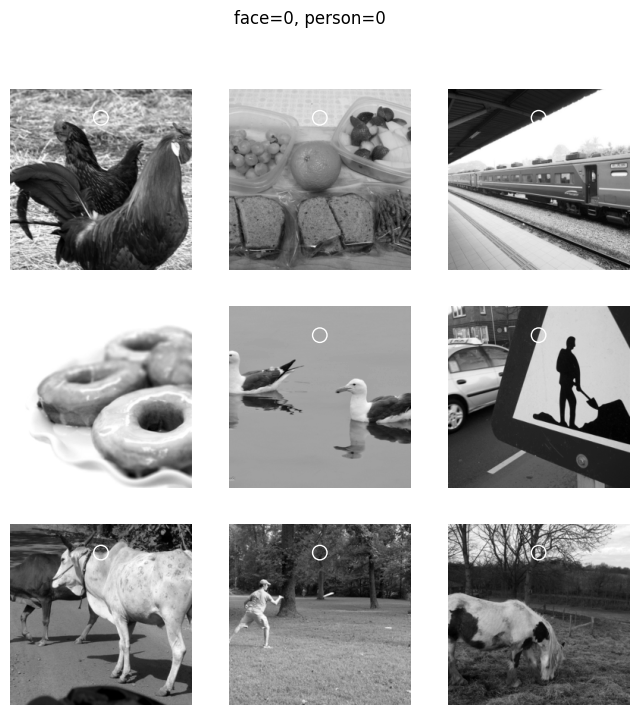

In [16]:
# plot examples - "has neither" patches

ims2use = np.where((has_face[:,prf_ind]==0) & (has_person==0) & \
                   np.isin(np.arange(10000), ims2load))[0]

images2plot = np.random.choice(ims2use,9);

center_in_image = np.array((n_pix/2 + x*n_pix, n_pix/2 - n_pix*y))
size_in_image = 2*sigma*n_pix

plt.figure(figsize=(8,8));

for ii, im in enumerate(images2plot):
    ax = plt.subplot(3,3,ii+1);
    plt.imshow(np.moveaxis(image_data[im,:,:,:],[0],[2]),cmap='gray')
    circ = matplotlib.patches.Circle(center_in_image, size_in_image, 
                                                 color = 'w', fill=False)
    ax.add_artist(circ)
    plt.axis('off')
    
    plt.suptitle('face=%d, person=%d'%(has_face[im, prf_ind], has_person[im]))

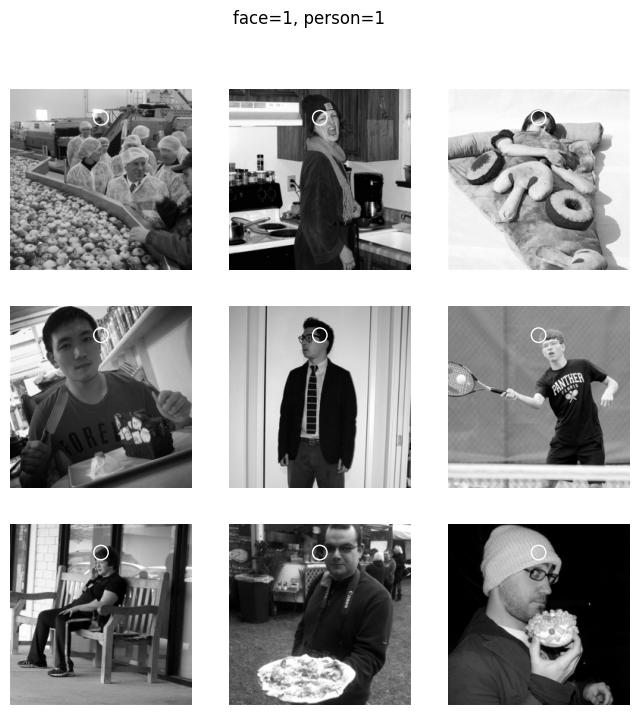

In [17]:
# plot examples - "has both" patches

ims2use = np.where((has_face[:,prf_ind]==1) & (has_person==1) & \
                   np.isin(np.arange(10000), ims2load))[0]

images2plot = np.random.choice(ims2use,9);

center_in_image = np.array((n_pix/2 + x*n_pix, n_pix/2 - n_pix*y))
size_in_image = 2*sigma*n_pix

plt.figure(figsize=(8,8));

for ii, im in enumerate(images2plot):
    ax = plt.subplot(3,3,ii+1);
    plt.imshow(np.moveaxis(image_data[im,:,:,:],[0],[2]),cmap='gray')
    circ = matplotlib.patches.Circle(center_in_image, size_in_image, 
                                                 color = 'w', fill=False)
    ax.add_artist(circ)
    plt.axis('off')
    
    plt.suptitle('face=%d, person=%d'%(has_face[im, prf_ind], has_person[im]))

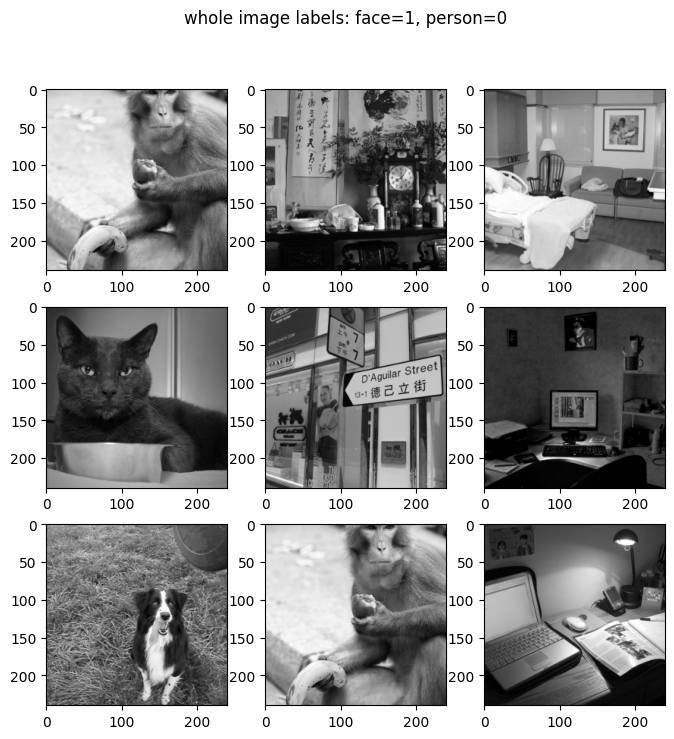

In [18]:
# plot examples - "has face" whole images

ims2use = np.where((has_face_wholeimage==1) & (has_person_wholeimage==0) & \
                   np.isin(np.arange(10000), ims2load))[0]

images2plot = np.random.choice(ims2use,9);

plt.figure(figsize=(8,8));

for ii, im in enumerate(images2plot):
    ax = plt.subplot(3,3,ii+1);
    plt.imshow(np.moveaxis(image_data[im,:,:,:],[0],[2]),cmap='gray')
   
    plt.suptitle('whole image labels: face=%d, person=%d'%(has_face_wholeimage[im], \
                                                             has_person_wholeimage[im]))

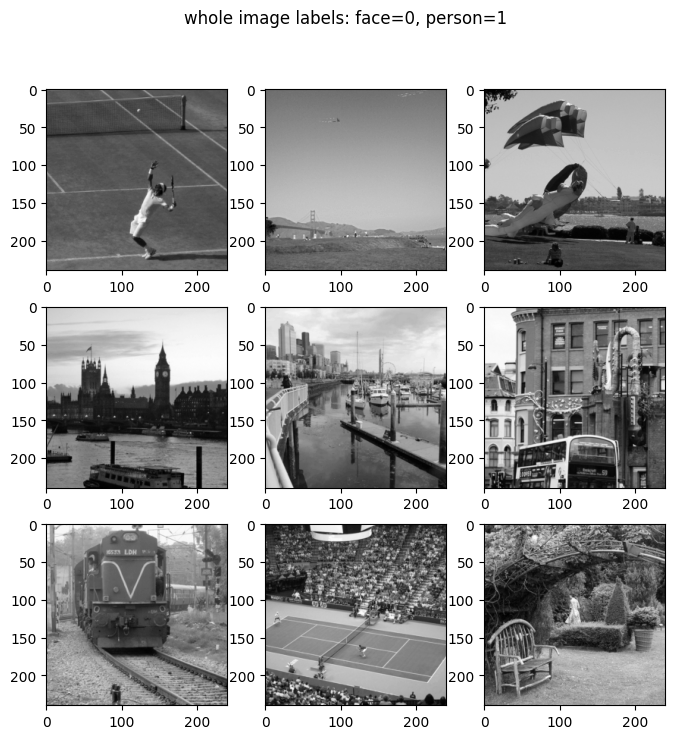

In [25]:
# plot examples - "has person" whole images

ims2use = np.where((has_face_wholeimage==0) & (has_person_wholeimage==1) & \
                   np.isin(np.arange(10000), ims2load))[0]

images2plot = np.random.choice(ims2use,9);

plt.figure(figsize=(8,8));

for ii, im in enumerate(images2plot):
    ax = plt.subplot(3,3,ii+1);
    plt.imshow(np.moveaxis(image_data[im,:,:,:],[0],[2]),cmap='gray')
   
    plt.suptitle('whole image labels: face=%d, person=%d'%(has_face_wholeimage[im], \
                                                             has_person_wholeimage[im]))

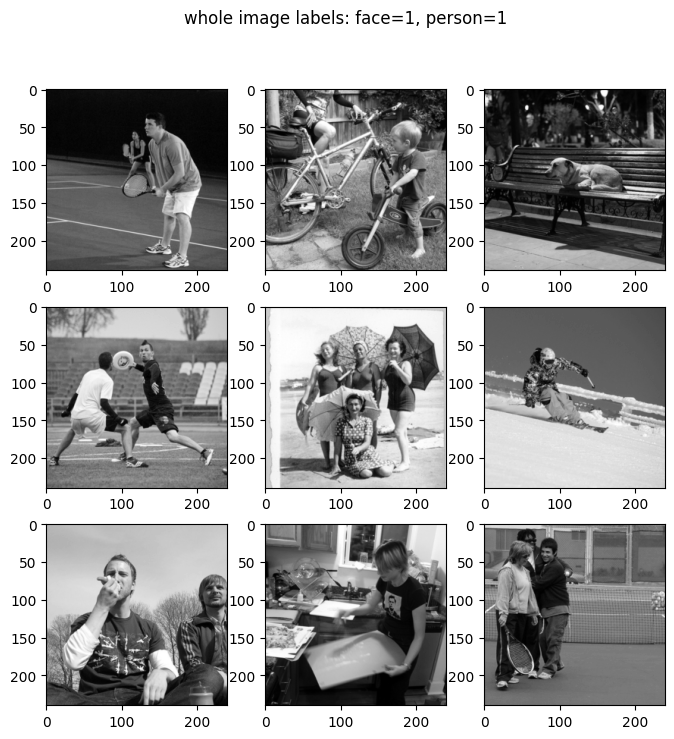

In [26]:
# plot examples - "has both" whole images

ims2use = np.where((has_face_wholeimage==1) & (has_person_wholeimage==1) & \
                   np.isin(np.arange(10000), ims2load))[0]

images2plot = np.random.choice(ims2use,9);

plt.figure(figsize=(8,8));

for ii, im in enumerate(images2plot):
    ax = plt.subplot(3,3,ii+1);
    plt.imshow(np.moveaxis(image_data[im,:,:,:],[0],[2]),cmap='gray')
   
    plt.suptitle('whole image labels: face=%d, person=%d'%(has_face_wholeimage[im], \
                                                             has_person_wholeimage[im]))

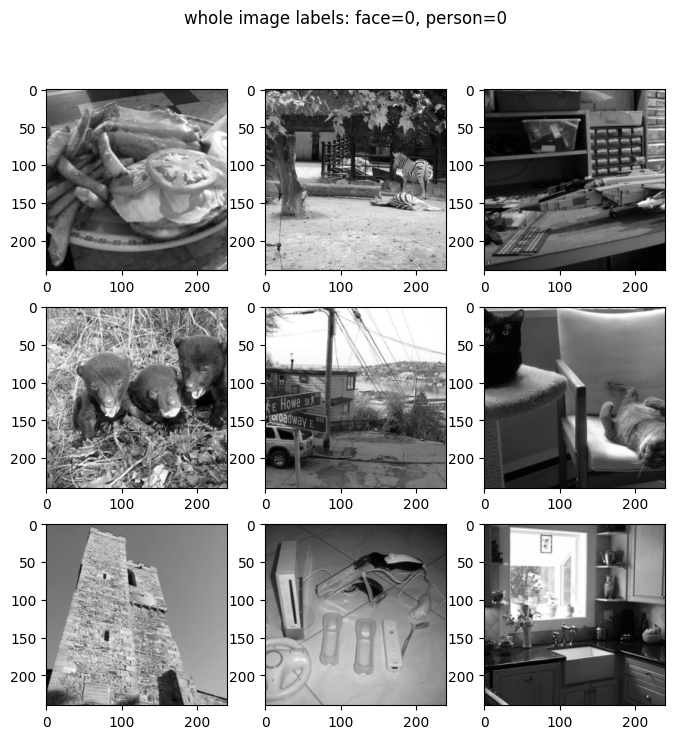

In [27]:
# plot examples - "has neither" whole images

ims2use = np.where((has_face_wholeimage==0) & (has_person_wholeimage==0) & \
                   np.isin(np.arange(10000), ims2load))[0]

images2plot = np.random.choice(ims2use,9);

plt.figure(figsize=(8,8));

for ii, im in enumerate(images2plot):
    ax = plt.subplot(3,3,ii+1);
    plt.imshow(np.moveaxis(image_data[im,:,:,:],[0],[2]),cmap='gray')
   
    plt.suptitle('whole image labels: face=%d, person=%d'%(has_face_wholeimage[im], \
                                                             has_person_wholeimage[im]))